# cityB SVR
ver20で越智さんの学習データの欠損値補完でちょっといい感じになった。
ここでは、クラスタリングをしてみてユーザーの行動タイプをセグメントわけでくるか見てみる

#### 設定

In [1]:
# BLEUのインストール
!git clone https://github.com/yahoojapan/geobleu.git
!pip install geobleu/

fatal: destination path 'geobleu' already exists and is not an empty directory.
Processing ./geobleu
  Preparing metadata (setup.py) ... done
  Created wheel for geobleu: filename=geobleu-0.3-py3-none-any.whl size=5037 sha256=38c57ce21f66ed98da2ff34c86d7bf8976c3adfb34331523a73e98b47fd93e07
  Stored in directory: /tmp/pip-ephem-wheel-cache-6mv_noco/wheels/15/98/c8/330b8225e74188a134268a5ac7b536896fe9cc4650bc728bc9
Successfully built geobleu
  Attempting uninstall: geobleu
    Found existing installation: geobleu 0.3
    Uninstalling geobleu-0.3:
      Successfully uninstalled geobleu-0.3


In [56]:
import pandas as pd
import numpy as np
import geobleu
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [3]:
INPUT_PATH = "../../s3storage/01_public/humob-challenge-2024/input/cityB_challengedata.csv.gz"
# INPUT_PATH = "/kaggle/input/humob2024/cityB_challengedata.csv/hiroshima_challengedata.csv"

#### データ読み込み

In [4]:
df_city_b = pd.read_csv(INPUT_PATH)
df_city_b.head(3)

,uid,d,t,x,y
0,0,0,20,80,99
1,0,0,21,81,97
2,0,0,25,83,102


#### ユーザーを絞り込み、d=60前後で訓練データと正解データに分割

In [5]:
# uidが20000~21999のデータを検証に利用
df_city_b_valid = (
    df_city_b
    .loc[df_city_b["uid"].between(20000, 21999)]
    # .loc[df_city_b["uid"].between(20000, 20010)]

)
df_city_b_valid.head(3)

,uid,d,t,x,y
20253615,20000,0,0,79,89
20253616,20000,0,2,79,89
20253617,20000,0,5,79,89


In [6]:
# dが60前後でデータを分割
df_city_b_train = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] < 60]
)

df_city_b_answer = (
    df_city_b_valid
    .loc[df_city_b_valid["d"] >= 60]
)

### 今回は実際のデータの傾向を見たいため、補間しない

In [10]:
# INTEROILATE_N = 8
# df_city_b_train_ip = interpolate_missing_values(df_city_b_train_full,INTEROILATE_N)

補完数：1269880


### 特徴量の作成

In [9]:
def attach_feature_data_and_time(df):
    df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
    df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
    df["date_ant_time_alpha_t"] = np.sin(2 * np.pi/24 * df["t"])
    df["date_ant_time_beta_t"] = np.cos(2 * np.pi/24 * df["t"])
    return df

In [10]:
def attach_feature_activity_time(df):
    # act の定義: 18 ≤ t < 23 または 33 ≤ t < 38
    df['act'] = np.where(((df['t'] >= 18) & (df['t'] < 23)) | ((df['t'] >= 33) & (df['t'] < 38)), 1, 0)

    # high_act の定義: 23 ≤ t < 33
    df['high_act'] = np.where((df['t'] >= 23) & (df['t'] < 33), 1, 0)

    # rest の定義: 13 ≤ t < 18 または 38 ≤ t < 44
    df['rest'] = np.where(((df['t'] >= 13) & (df['t'] < 18)) | ((df['t'] >= 38) & (df['t'] < 44)), 1, 0)

    # deep_rest の定義: 0 ≤ t < 13 または 44 ≤ t < 48
    df['deep_rest'] = np.where(((df['t'] >= 0) & (df['t'] < 13)) | ((df['t'] >= 44) & (df['t'] < 48)), 1, 0)

    return df

In [11]:
def attach_feature_day_of_week(df):
    # d = 0が2020/1/5に対応
    df["date"]  = pd.to_datetime("2020-01-05") + pd.to_timedelta(df["d"],unit="D")
    
    # 曜日 0:Mon,... 5:Sat,6:Sun
    df["dow"] = df["date"].dt.weekday
    
    return df.drop(columns = ["date"])

In [12]:
def attach_feature_weekday_holiday(df):
    df['weekdays'] = df['dow'].apply(lambda x: 0 if x in [5, 6] else 1)

    return df

In [13]:
def attach_feature_am_pm(df):
    # AM フラグを設定: 0 ≤ t < 25 は 1、それ以外は 0
    df['AM'] = np.where((df['t'] >= 0) & (df['t'] < 25), 1, 0)
    
    # # PM フラグを設定: AM が 0 の場合は PM は 1、AM が 1 の場合は PM は 0
    # df['PM'] = np.where(df['AM'] == 1, 0, 1)
    return df

In [14]:
def attach_features(df):
    df = attach_feature_data_and_time(df)
    df = attach_feature_activity_time(df)
    df = attach_feature_day_of_week(df)
    df = attach_feature_weekday_holiday(df)
    df = attach_feature_am_pm(df) 
    return df

In [15]:
# 学習データに特徴量付与
df_city_b_train = attach_features(df_city_b_train)
df_city_b_train.head(2)

/tmp/ipykernel_389356/2592063384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_ant_time_alpha_d"] = np.sin(2 * np.pi/7 * df["d"])
/tmp/ipykernel_389356/2592063384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_ant_time_beta_d"] = np.cos(2 * np.pi/7 * df["d"])
/tmp/ipykernel_389356/2592063384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,uid,d,t,x,y,date_ant_time_alpha_d,date_ant_time_beta_d,date_ant_time_alpha_t,date_ant_time_beta_t,act,high_act,rest,deep_rest,dow,weekdays,AM
20253615,20000,0,0,79,89,0.0,1.0,0.0,1.000000,0,0,0,1,6,0,1
20253616,20000,0,2,79,89,0.0,1.0,0.5,0.866025,0,0,0,1,6,0,1


In [103]:
uid_features = (
    df_city_b_train
    .drop(columns=["d","t","x","y"])
    .groupby("uid").agg({
        'date_ant_time_alpha_t': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'date_ant_time_beta_t': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'act': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'high_act': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'rest': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'deep_rest': ['sum', lambda x: x.mode()[0]],  # 合計と最頻値
        'dow': [lambda x: x.mode()[0]],  # 最頻値
        'weekdays': [lambda x: x.mode()[0]],  # 最頻値
        'AM': [lambda x: x.mode()[0]],  # 最頻値
    })
)
# .reset_index()

In [104]:
uid_features.columns = ['_'.join(col).replace('<lambda_0>', 'mode').replace('<lambda>', 'mode') for col in uid_features.columns]
uid_features.reset_index()

,uid,date_ant_time_alpha_t_sum,date_ant_time_alpha_t_mode,date_ant_time_beta_t_sum,date_ant_time_beta_t_mode,act_sum,act_mode,high_act_sum,high_act_mode,rest_sum,rest_mode,deep_rest_sum,deep_rest_mode,dow_mode,weekdays_mode,AM_mode
0,20000,-93.311012,-1.000000e+00,-4.638285,1.000000,234,0,269,0,291,0,269,0,1,1,0
1,20001,-4.799539,3.673940e-16,-109.790141,-1.000000,229,0,217,0,171,0,63,0,6,1,0
2,20002,-62.411104,-8.660254e-01,-6.342459,-0.500000,187,0,222,0,165,0,51,0,2,1,0
3,20003,-25.911235,8.660254e-01,34.970594,-0.500000,218,0,263,0,167,0,151,0,3,1,1
4,20004,-64.129681,-8.660254e-01,-46.973006,-0.500000,236,0,220,0,166,0,13,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,21995,-69.728783,3.673940e-16,-78.915594,-1.000000,181,0,139,0,160,0,52,0,6,1,0
1996,21996,-44.285502,-2.588190e-01,-65.670254,-0.965926,164,0,163,0,256,0,287,0,6,1,1
1997,21997,-29.578096,2.588190e-01,-108.698475,-0.965926,179,0,142,0,139,0,34,0,6,1,0
1998,21998,-15.024519,2.588190e-01,-221.442018,-0.965926,247,0,158,0,178,0,15,0,2,1,0


In [105]:
feature_list = [
    'date_ant_time_alpha_t_sum',
    'date_ant_time_alpha_t_mode',
    'date_ant_time_beta_t_sum',
    'date_ant_time_beta_t_mode',
    'act_sum',
    'act_mode',
    'high_act_sum',
    'high_act_mode',
    'rest_sum',
    'rest_mode',
    'deep_rest_sum',
    'deep_rest_mode',
    'dow_mode',
    'weekdays_mode',
    'AM_mode',
]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

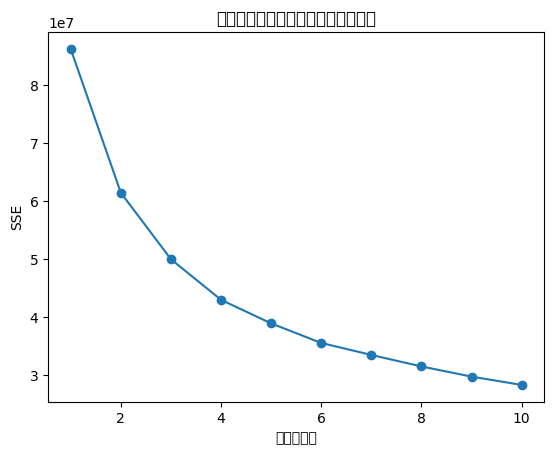

In [106]:
# SSE（クラスタ内誤差）のリスト
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(uid_features[feature_list])
    sse.append(kmeans.inertia_)

# クラスタ数ごとのSSEをプロット
plt.plot(range(1, 11), sse, marker='o')
plt.rcParams['font.family'] = 'IPAexGothic'
plt.xlabel('クラスタ数')
plt.ylabel('SSE')
plt.title('エルボー法によるクラスタ数の選択')
plt.show()

In [107]:
kmeans = KMeans(n_clusters=4, random_state=119)
uid_features['cluster'] = kmeans.fit_predict(
    uid_features[feature_list]
)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [108]:
uid_features["cluster"].value_counts()

cluster
1    711
0    539
3    463
2    287
Name: count, dtype: int64

In [109]:
score = silhouette_score(uid_features[feature_list], uid_features["cluster"])
score

0.22302325990353794

### T-SNEで次元削減して可視化

In [110]:
# t-SNEによる次元削減
tsne = TSNE(n_components=2, perplexity=30,random_state=0)
tsne_result = tsne.fit_transform(uid_features[feature_list])

In [111]:
# t-SNEの結果をDataFrameに格納
uid_features['tsne_1'] = tsne_result[:, 0]
uid_features['tsne_2'] = tsne_result[:, 1]

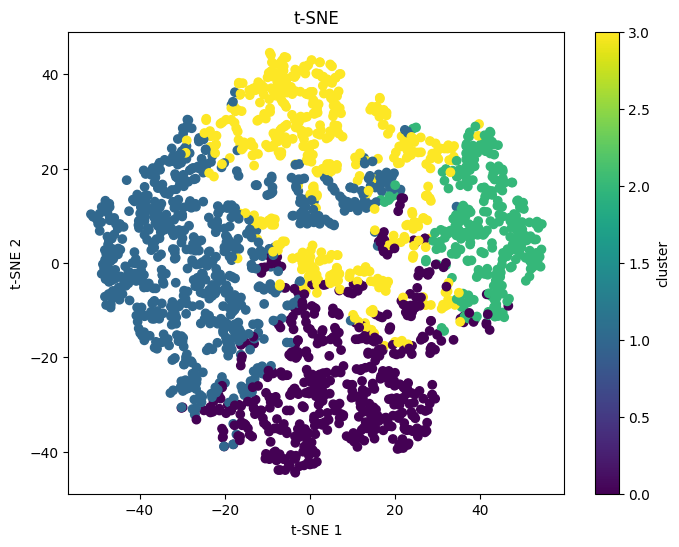

In [112]:
# t-SNE結果をクラスタごとに可視化
plt.figure(figsize=(8, 6))
plt.scatter(uid_features['tsne_1'], uid_features['tsne_2'], c=uid_features['cluster'], cmap='viridis')
plt.title('t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='cluster')
plt.show()

t-SNEって大体なんかいい感じに見えるよね！！

## 各uidごとのcluster番号を出力

In [93]:
uid_features

,date_ant_time_alpha_t_sum,date_ant_time_alpha_t_mode,date_ant_time_beta_t_sum,date_ant_time_beta_t_mode,act_sum,act_mode,high_act_sum,high_act_mode,rest_sum,rest_mode,deep_rest_sum,deep_rest_mode,dow_mode,weekdays_mode,AM_mode,cluster,tsne_1,tsne_2
uid,,,,,,,,,,,,,,,,,,
20000,-93.311012,-1.000000e+00,-4.638285,1.000000,234,0,269,0,291,0,269,0,1,1,0,2,37.650208,3.905601
20001,-4.799539,3.673940e-16,-109.790141,-1.000000,229,0,217,0,171,0,63,0,6,1,0,0,-7.659823,1.260390
20002,-62.411104,-8.660254e-01,-6.342459,-0.500000,187,0,222,0,165,0,51,0,2,1,0,1,-7.921161,-12.503504
20003,-25.911235,8.660254e-01,34.970594,-0.500000,218,0,263,0,167,0,151,0,3,1,1,0,5.862438,-15.700132
20004,-64.129681,-8.660254e-01,-46.973006,-0.500000,236,0,220,0,166,0,13,0,2,1,0,0,-1.498572,-9.229988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,-69.728783,3.673940e-16,-78.915594,-1.000000,181,0,139,0,160,0,52,0,6,1,0,3,-13.386953,22.794828
21996,-44.285502,-2.588190e-01,-65.670254,-0.965926,164,0,163,0,256,0,287,0,6,1,1,2,36.585201,18.649099
21997,-29.578096,2.588190e-01,-108.698475,-0.965926,179,0,142,0,139,0,34,0,6,1,0,1,-16.704689,9.356404


In [113]:
uid_features.reset_index()[["uid","cluster"]].to_csv("basic_features_clustering.csv",index=False)